In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

# Parte 1

### Informazioni di base sul Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È costituito da una serie di spin (che possono assumere solo i valori -1 (down) e +1 (up)) interagenti tra loro, posti ai vertici di un reticolo quadrato bidimensionale. La dinamica del sistema (in assenza di campo magnetico esterno)

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.

Si può dimostrare che questo sistema presenta una transizione di fase nel limite termodinamico da un sistema ordinato con tutti gli spin allineati (ferromagnete ordinato) a temperatura zero, a una fase disordinata con spin competamente random, ad alta temperatura. La temperatura critica a cui avviene la transizione è data da $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$.


 ATTENZIONE: le configurazioni sono salvate in file testuali, che letti con numpy (*np.loadtxt*) forniscono tensori di shape *(25000x28,28)* che vanno reshaped nel formato *(25000,28x28)* e *(25000,28,28)* per essere utilizzati con scikit-learn in modo efficiente.

**Procedimento che verrà seguita:**

Loading, analisi e pre-processamento del dataset:

1.   leggere le configurazioni e salvarle in due tensori numpy *data(25000,784)* e *data_2d(25000,28,28)*, usando il metodo *np.loadtxt* di numpy. Idem per le temperature: *temp(25000,1)*
2.   poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dvidere il campione in tre sotto-campioni corrispondenti alle classi:

* ordinato: $T<2.0$
* critico: $2.0\leq T\leq 2.5$
* disordinato: $T>2.5$

     costruendo un nuovo tensore numpy di label *(0,1,2)* da associare ad ogni configurazione in *data/data_2d*.
    
3.   visualizzare un evento per ciascuna classe usando matplotlib: *plt.imshow*  (nota: usare il tensore in formato (28,28) *data_2d*)

In [2]:
seed = 123456
np.random.seed(seed) # shuffle random seed generator

# Ising model parameters
L=28                                            # size del reticolo
J=1.0                                           # Ising interaction (1 ferromagnetico, -1 anti-ferromagnetico)
T_c=2.26                                        # Temperatura critica

# Leggo i file e li assegno alla variabile data e la ridimensiono come richiesto
data=np.loadtxt('ising_conf.dat')
data=data.reshape(25000,28*28)

data_2d = data.reshape(data.shape[0],28,28)     # Seconda configurazione

temp = np.loadtxt('ising_label.dat')            # Leggo il file della temperatura e lo assegno a temp


In [3]:
ordinato = (temp < 2.0)                    #crea un numpy array in cui assegna true alla componente i se temp[i]<2.0, false altrimenti
critico = ((temp >= 2.0) & (temp <= 2.5))  #crea un numpy array in cui assegna true alla componente i se temp[i]>=2.0 & <=2.5, false altrimenti
disordinato = (temp > 2.5)                 #crea un numpy array in cui assegna true alla componente i se temp[i]>2.5, false altrimenti

labels = np.zeros(shape=temp.shape)        # Creo un numpy array con shape uguale a temp

# Ora creo il mio array di labels con valori 0,1,2 in base agli array ordinato, critico e disordinato creati prima, quindi per esempio, a labels[ordinato]=0, assegna 0 a tutte le componenti true dell'array ordinato, assegnando però il valore all'array labels, uguale per le altre 2 istruzioni.
labels[ordinato]=0
labels[critico]=1
labels[disordinato]=2

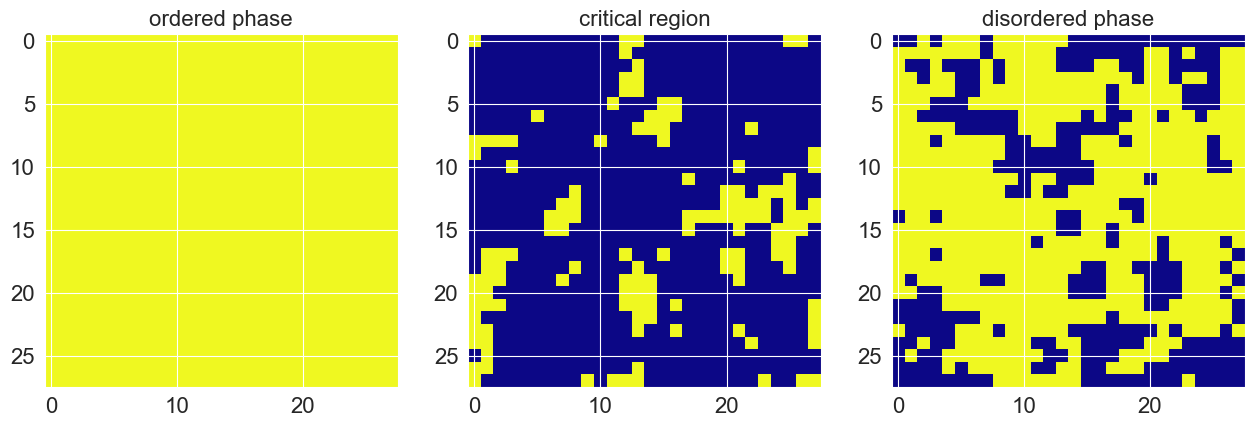

In [4]:
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

ieve = 567 #seleziono un evento a caso di ogni classe
axarr[0].imshow((data_2d[ordinato])[ieve],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow((data_2d[critico])[ieve],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow((data_2d[disordinato])[ieve],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

# Parte 2

**Parte 2**:

Implementazione di dueclassificatori basati su un **albero di decisione binaria, una random forest (basata su bagging)**, addestrati alla task di identificare la classe (0,1,2) delle configurazioni (ordinata, critica, disordinata).


**Procedura che verrà seguita**

1.   dividere campione e label in tre sotto-campioni: **training, validation e test set** (*60-20-20 %*) usando sklearn:


2.   implementare e **addestrare sul campione di training** i due classificator:


3.   usando come metrica l'accuracy, **ottmizzare gli iperparametri** dei modelli (NOTA: valutare l'accuracy sia sul **training set** che sul **validation set** e usare quest'ultima come misura non distorta delle prestazioni in generalizzazione del modello):

*   DecisionTreeClassifier: *max_depth*, 10 valori in [1,10]
*   RandomForestClassifier: *n_estimators*, 10 valori in [2,100], e *min_samples_split*, testare 2 valori per il parametro =2 e =10000

4.  insieme all'accuracy stimata sul test calcolare anche l'accuracy sul campione Out-Of-Bag (OOB: disponibile solo per le RandomForest, vedi la nota successiva per una spiegazione)
5.   graficare accuracy e stima OOB sul training e test set in funzione del valore del parametro ottimizzato
6.   confrontare in termini di **accuracy media** e **matrice di confusione** calcolate sul *campione di test* i risultati ottenuti con i due modelli ottimizzati

In [5]:
# Prima divisione: 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Seconda divisione: dividere il 25% (20% del 80%) del training set per la validazione, lasciando il restante 75% come training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(15000, 784)
(5000, 784)
(5000, 784)
(15000,)
(5000,)
(5000,)


## Classificatore con Albero Decisionale

miglior max_depth: 8 con accuratezza: 0.843
Il miglior modello di decision tree classifier, avrà dunque, sul test set, accuratezza: 0.8402


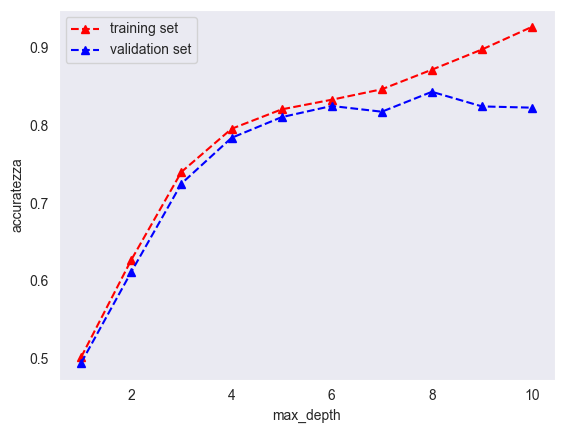

In [6]:
max_depth_range=np.arange(1,11,1,dtype=int)   # Range del max depth dove andro ad ottimizzare il modello
acc_train=[]
acc_val=[]
# inizializzo il for dove faro scorrere i max depth all'interno del modello e registreto dunque l'accuracy rispetto ad ogni valore di max depth utilizzato
for i in max_depth_range:
    model_tree = DecisionTreeClassifier(max_depth=i)
    model_tree.fit(X_train, y_train)
    acc_tree_train = model_tree.score(X_train, y_train)
    acc_tree_val = model_tree.score(X_val, y_val)
    acc_train.append(acc_tree_train)
    acc_val.append(acc_tree_val)

best_max_depth = max_depth_range[acc_val.index(max(acc_val))]   #mi restituisce l'indice in cui ho l'accuratezza migliore con il quale estrarre il corrispondente valore di max_depth nella lista, quindi quello a cui corrisponde la migliore accuratezza
print("miglior max_depth:", best_max_depth, "con accuratezza:", max(acc_val))


#modello finale sul valore ottimizzato di max depth
model_tree = DecisionTreeClassifier(max_depth=best_max_depth)
model_tree.fit(X_train, y_train)
acc_tree_test=model_tree.score(X_test,y_test)
print("Il miglior modello di decision tree classifier, avrà dunque, sul test set, accuratezza:", acc_tree_test)


# plotto gli andamenti dell'accuratezza in funzione dei max depth sul validation e training set
plt.plot(max_depth_range,acc_train, '--r^', label='training set')
plt.plot(max_depth_range,acc_val, '--b^' , label='validation set')
plt.xlabel('max_depth')
plt.ylabel('accuratezza')
plt.legend()
plt.grid()
plt.show()

## Classificatore con Random Forest

miglior n_estimators: 61 con accuratezza: 0.9204 min_samples_split: 2 OOB: 0.9151333333333334
Il miglior modello di Random Forest Classifier, avrà dunque, sul test set, accuratezza: 0.9184


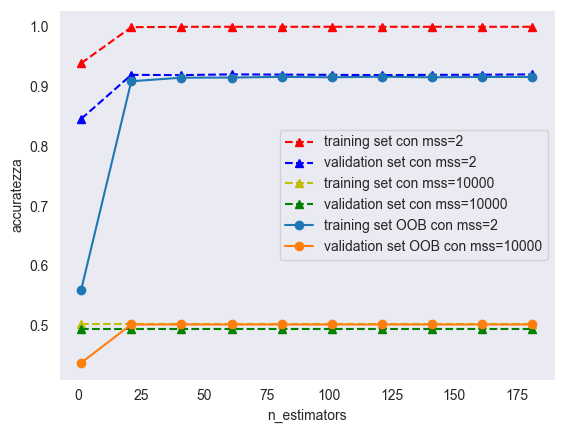

In [27]:
import warnings
#disabilitiamo messaggi di warning
warnings.filterwarnings("ignore")

# Stessi identici passaggi però con qualche accortezza in più perchè questa volta vanno ottimizzati 2 parametri, n_estimators su un range di valore, e tutti questi valori su altri due del parametro min_samples_split. Quindi verranno inizializzate più varriabili, due for uno dentro l'altro e condizioni if per distinguere su quale min_samples_split ci si trova

n_estimators_range=np.arange(1,201,20, dtype=int)
min_samples_split_range=np.array([2,10000])
acc_train2=[]
acc_val2=[]
acc_oob1=[]
acc_train3=[]
acc_val3=[]
acc_oob2=[]

for j in min_samples_split_range:
    for i in n_estimators_range:
        model_forest = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=j, oob_score=True, random_state=0, warm_start=True)
        model_forest.fit(X_train, y_train)
        acc_forest_train = model_forest.score(X_train, y_train)
        acc_forest_val = model_forest.score(X_val, y_val)
        acc_oob = model_forest.oob_score_
        if j == min_samples_split_range[0]:
            acc_train2.append(acc_forest_train)
            acc_val2.append(acc_forest_val)
            acc_oob1.append(acc_oob)
        else:
            acc_train3.append(acc_forest_train)
            acc_val3.append(acc_forest_val)
            acc_oob2.append(acc_oob)
        
if max(acc_val2) >= max(acc_val3):
    best_min_samples_split=min_samples_split_range[0]
    best_n_estimators = n_estimators_range[acc_val2.index(max(acc_val2))]
    print("miglior n_estimators:", best_n_estimators, "con accuratezza:", max(acc_val2), "min_samples_split:", best_min_samples_split, "OOB:" ,acc_oob1[acc_val2.index(max(acc_val2))])
else:
    best_min_samples_split=min_samples_split_range[1]
    best_n_estimators = n_estimators_range[acc_val3.index(max(acc_val3))]
    print("miglior n_estimators:", best_n_estimators, "con accuratezza:", max(acc_val2),  "min_samples_split:", best_min_samples_split, "OOB:", acc_oob2[acc_val3.index(max(acc_val3))])

model_forest = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=None, min_samples_split=best_min_samples_split, oob_score=True, random_state=0, warm_start=True)
model_forest.fit(X_train, y_train)
acc_forest_test=model_forest.score(X_test,y_test)
print("Il miglior modello di Random Forest Classifier, avrà dunque, sul test set, accuratezza:", acc_forest_test)

plt.plot(n_estimators_range,acc_train2, '--r^', label='training set con mss=2')
plt.plot(n_estimators_range,acc_val2, '--b^' , label='validation set con mss=2')
plt.plot(n_estimators_range,acc_train3, '--y^', label='training set con mss=10000')
plt.plot(n_estimators_range,acc_val3, '--g^' , label='validation set con mss=10000')
plt.plot(n_estimators_range,acc_oob1, 'o-', label='training set OOB con mss=2')
plt.plot(n_estimators_range,acc_oob2, 'o-' , label='validation set OOB con mss=10000')
plt.xlabel('n_estimators')
plt.ylabel('accuratezza')
plt.legend()
plt.grid()
plt.show()

# Parte 3

Allenare un regressore RandomForest (RandomForestRegressor) al task di predire la magnetizzazione media $\hat{M}$ a partire da una configurazione di spin di temperatura nota $T$.

1.   costruire il tensore magnetizzazione media $M$ per ogni elemento dei campioni X_test, X_vali e X_train:


> $M = \frac{1}{N}\sum_i^N S_i$

2.   implementare e allenare il regressore sul training set, usando come loss: MSE
3.   ottimizzare la dimensione della foresta (n_estimators) sul validation set
4.   stimare prestazioni (MAE) sul test set e graficare sul test set lo scatter plot $\hat{M}$ VS $M$ predetta, e l'istogramma di ($M-\hat{M}$)
5.   provare a dare una spiegazione di quanto osservato ...

In [39]:
M_train = np.zeros(len(X_train))
M_test = np.zeros(len(X_test))
M_val = np.zeros(len(X_val))

for i in range(len(X_train)):
    M_train[i]=np.sum(X_train[i,:])/784

for i in range(len(X_test)):
    M_test[i]=np.sum(X_test[i,:])/784
    M_val[i]=np.sum(X_val[i,:])/784


In [38]:
warnings.filterwarnings("ignore")

model_regressor = RandomForestRegressor(n_estimators=20, criterion='friedman_mse', max_depth=None, oob_score=True, random_state=0, warm_start=True)
model_regressor.fit(X_train, M_train)
acc_regressor_train=model_regressor.score(X_train,M_train)
acc_regressor_test=model_regressor.score(X_test,M_test)
acc_regressor_val=model_regressor.score(X_val,M_val)
print('coeff. of determination R^2 score (train/vali/test): ',acc_regressor_train,acc_regressor_val, acc_regressor_test)

pred=model_regressor.predict(X_test)
mae=mean_absolute_error(M_test, pred)

print("Mean-Absolute Error:",mae)

coeff. of determination R^2 score (train/vali/test):  0.9973887882291835 0.9902287311788087 0.9900394543982678
Mean-Absolute Error: 0.03901678571428571
